In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

from glash import Glash
tf.random.set_random_seed(42)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
no_samples = 500

test_obj = Glash(no_samples, [no_samples])
test_obj.glash_compile()

batch_size = 100
dataset = [np.random.normal(np.random.randint(0, 10), 
                            np.round(np.random.uniform(0, 1), decimals=2), 
                            no_samples) for i in range(1000)]

dataset = test_obj.data_processing(dataset, batch_size)

test_obj.train_glash(dataset, batch_size)
new = np.array([np.random.normal(1, 0.2, no_samples)])
test = test_obj.glash_predict(new)

2021-11-03 22:26:33.884203: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-03 22:26:33.884352: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-03 22:26:33.885421: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-11-03 22:26:34.259492: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-03 22:26:34.284605: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


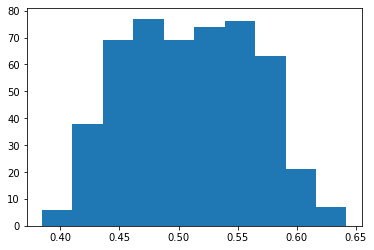

In [3]:
plt.hist(test)
plt.show()

(array([ 1.,  0.,  3.,  2.,  3.,  5., 11.,  6.,  7.,  9., 13., 13., 14.,
        13., 16., 18., 11., 21., 13., 17., 15., 13., 17.,  8., 16., 13.,
        19., 15., 16., 18., 18., 13.,  8., 20., 15., 19.,  9., 12., 11.,
         3., 13.,  4.,  2.,  0.,  1.,  2.,  2.,  1.,  0.,  1.]),
 array([0.39725864, 0.40194252, 0.40662643, 0.41131032, 0.41599423,
        0.4206781 , 0.42536202, 0.4300459 , 0.4347298 , 0.4394137 ,
        0.44409758, 0.4487815 , 0.45346537, 0.45814928, 0.46283317,
        0.46751708, 0.47220096, 0.47688484, 0.48156875, 0.48625264,
        0.49093655, 0.49562043, 0.50030434, 0.50498825, 0.5096721 ,
        0.514356  , 0.5190399 , 0.5237238 , 0.5284077 , 0.5330916 ,
        0.5377755 , 0.54245937, 0.5471433 , 0.5518272 , 0.55651104,
        0.56119496, 0.56587887, 0.5705628 , 0.57524663, 0.57993054,
        0.58461446, 0.58929837, 0.5939822 , 0.59866613, 0.60335004,
        0.6080339 , 0.6127178 , 0.6174017 , 0.62208563, 0.6267695 ,
        0.6314534 ], dtype=float32),

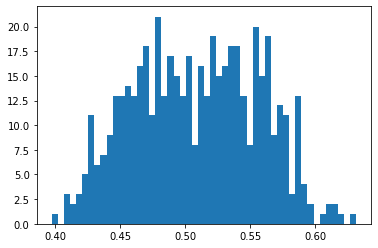

In [4]:
new_2 = np.array([np.random.uniform(1, 0.2, no_samples)])
test_2 = test_obj.glash_predict(new_2)
plt.hist(test_2, bins=50)

(array([ 1.,  4.,  6., 18., 16., 25., 27., 34., 31., 30., 25., 27., 29.,
        31., 30., 31., 24., 38., 26., 19., 18.,  3.,  2.,  2.,  3.]),
 array([0.38727868, 0.39734146, 0.4074042 , 0.417467  , 0.42752978,
        0.43759254, 0.44765532, 0.45771807, 0.46778086, 0.47784364,
        0.4879064 , 0.49796918, 0.50803196, 0.5180947 , 0.5281575 ,
        0.5382203 , 0.54828304, 0.5583458 , 0.5684086 , 0.57847136,
        0.5885341 , 0.59859693, 0.6086597 , 0.61872244, 0.62878525,
        0.638848  ], dtype=float32),
 <BarContainer object of 25 artists>)

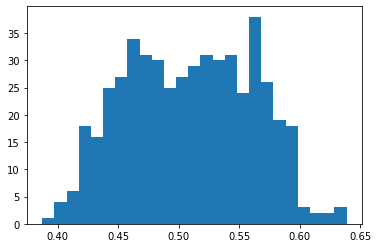

In [5]:
new_3 = np.array([np.random.uniform(3, 0.1, no_samples)])
test_3 = test_obj.glash_predict(new_3)
plt.hist(test_3, bins=25)